# Metasurface test

In [1]:
import numpy as np
from timeit import default_timer as timer
import matplotlib.pyplot as plt


from ngsolve import *
from ngsolve.webgui import Draw
from ngsolve.krylovspace import GMRes

from cross import create_cross_mesh
from mat_indices import ag_n, ag_k, al_n, al_k, glass_n, glass_k

ngsglobals.msg_level = 1

In [2]:
nel = 12
#it is certainly smaller than this
n_glass = 1.55
min_wavelength = 1

w_domain = 0.8
h_domain = 0.7
w_cross = 0.05
l_cross = 0.5
h_silver = 0.3
h_sub = 0.1
h_pml = 0.1
el_ag = min_wavelength/nel
el_air = min_wavelength/nel
el_sub = n_glass*min_wavelength/nel
d_cross = 0.2

## Create mesh

In [3]:
mesh = create_cross_mesh(w_domain,h_domain,w_cross,l_cross,d_cross,
                         h_silver,h_sub,h_pml,el_ag,el_air,el_sub)

#these dictionaries will be useful for inspecting the mesh

#name of all 3d domains
vollist = {"air":1, "ag":2, "sub":3, "pml_air":4,
           "pml_sub":5}

#name of all 2d domains
surflist = {
    'air_port': 1,
    'sub_port' : 2,
    'dirichlet' : 3,
    }
count = len(surflist)+1
for name in vollist.keys():
    surflist[name+"_x_min"] = count
    count+=1
    surflist[name+"_x_max"] = count
    count+=1
    surflist[name+"_y_min"] = count
    count+=1
    surflist[name+"_y_max"] = count
    count+=1

Draw(mesh)

 Delaunay meshing
 Delaunay meshing
 start tetmeshing
 Success !
 Delaunay meshing
 Delaunay meshing
 Delaunay meshing
 Volume Optimization


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

### Check boundary materials

In [4]:
print(surflist)
surf = mesh.BoundaryCF(surflist, -1)
g = GridFunction(H1(mesh), name='bdry')
g.Set(surf, definedon=mesh.Boundaries('.*'))
Draw(g);

{'air_port': 1, 'sub_port': 2, 'dirichlet': 3, 'air_x_min': 4, 'air_x_max': 5, 'air_y_min': 6, 'air_y_max': 7, 'ag_x_min': 8, 'ag_x_max': 9, 'ag_y_min': 10, 'ag_y_max': 11, 'sub_x_min': 12, 'sub_x_max': 13, 'sub_y_min': 14, 'sub_y_max': 15, 'pml_air_x_min': 16, 'pml_air_x_max': 17, 'pml_air_y_min': 18, 'pml_air_y_max': 19, 'pml_sub_x_min': 20, 'pml_sub_x_max': 21, 'pml_sub_y_min': 22, 'pml_sub_y_max': 23}


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

### Check volume materials

In [5]:
mat_cf = mesh.MaterialCF(vollist)
print(mesh.GetMaterials())
Draw(mat_cf, mesh, draw_surf=False);

('pml_air', 'air', 'ag', 'sub', 'pml_sub')


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

## Sweep over frequency range

In [9]:
wl_list = np.arange(1,1.1,0.005)
porder = 3
ref_list = []
for it, wl in enumerate(wl_list):    
    print("solving {} out of {}".format(it+1,len(wl_list)))
    ag_coeff = (ag_n(wl)-ag_k(wl)*1j)**2
    #for now, silver instead of glass
    sub_coeff = (ag_n(wl)-ag_k(wl)*1j)**2
    air_coeff = 1

    # defining permittivity for volume domains
    erlist = {
        'pml_air' : 1,
        'air' : 1,
        'ag' : ag_coeff,
        #for now, substrate is silver
        'sub' : sub_coeff,
        'pml_sub' : sub_coeff,
        }

    er = er = mesh.MaterialCF(erlist, 0)
    #non-magnetic materials only
    ur = CF(1)

    #now we define the PML regions
    alphapml = 1j

    boxmin = [-w_domain, -w_domain, 0]
    boxmax = [w_domain, w_domain, h_domain]
    ## i need to figure out if it is a problem to call SetPML at each iteration
    mesh.SetPML(pml.Cartesian(mins=boxmin, maxs=boxmax, alpha=alphapml),"pml_air|pml_sub")

    fes = Periodic(HCurl(mesh, order=porder, complex=True, dirichlet="dirichlet"))

    u, v = fes.TnT()

    kzero = 2*pi/wl
    a = BilinearForm(fes,condense=True,hermitian=False)
    a += ((1./ur) * curl(u) * curl(v) - kzero**2 * er * u * v)*dx

    f = LinearForm(fes)

    #our system is excited at the subdomain air port by a plane wave in the x direction
    #which is a constant vector field propagating with the propagation constant k0
    e_in = mesh.BoundaryCF({"air_port":(0, 1, 0)},(0,0,0))
    # print(e_in)
    f += (-2j*kzero * e_in * v.Trace()) * ds("air_port")
    print("assembling system with ndofs {}".format(sum(fes.FreeDofs())))
    pre = Preconditioner(a, "bddc")
    
    with TaskManager():
        a.Assemble()
        f.Assemble()

    print("done!")
    # the solution field 
    gfu = GridFunction(fes)
    print("solving...")
    direct = True
    s_begin = timer()
    if direct:
        with TaskManager():
            gfu.vec.data = a.mat.Inverse(fes.FreeDofs(),inverse="pardiso") * f.vec
    else:
        # pre = CreatePrecond(mesh, fes, a)
        res = f.vec.CreateVector()
        with TaskManager():
            gfu.vec.data = GMRes(a.mat, f.vec, pre=pre, maxsteps=300, tol=1e-7, printrates=True, restart=100)
            bc_projector = Projector(fes.FreeDofs(), True)
            res.data = bc_projector*(f.vec - a.mat * gfu.vec)
            print("res norm {}".format(Norm(res)))

    s_end = timer()

    print("solved system in {} seconds".format(s_end-s_begin))
    ref = Integrate(InnerProduct(gfu - e_in, gfu - e_in)/(InnerProduct(e_in, e_in)+1e-12),
                    mesh,BND, definedon=mesh.Boundaries("air_port"))
    ref_list.append(ref)
    print("ref {} !".format(abs(ref)))
    

    # plot the solution (netgen-gui only)
    #as it is, it should work. Draw (gfu)

solving 1 out of 21
assembling system with ndofs 124712
done!
solving...
solved system in 62.70651080698008 seconds
ref 0.7034495836769987 !
solving 2 out of 21
assembling system with ndofs 124712
done!
solving...
solved system in 67.33190920599736 seconds
ref 0.7120510902912771 !
solving 3 out of 21
assembling system with ndofs 124712
done!
solving...
solved system in 59.96821535599884 seconds
ref 0.724984472788374 !
solving 4 out of 21
assembling system with ndofs 124712
done!
solving...
solved system in 61.78387021494564 seconds
ref 0.744212989056444 !
solving 5 out of 21
assembling system with ndofs 124712
done!
solving...
solved system in 62.496199975023046 seconds
ref 0.7706479846760192 !
solving 6 out of 21
assembling system with ndofs 124712
done!
solving...
solved system in 60.96756042598281 seconds
ref 0.8094040915102604 !
solving 7 out of 21
assembling system with ndofs 124712
done!
solving...
solved system in 57.39085944299586 seconds
ref 0.8655741403791266 !
solving 8 out 

## Plotting data

In [10]:
def plot_data(wl, val, title):
    x = list(wl)nval = len(ref_list)
    y = list(np.abs(val))
    ax = plt.gca()
    ax.set_xlim([min(wl), max(wl)])
    print("min val: {} max val {}".format(min(y),max(y)))
    ax.set_ylim([0, 1])

    # plotting newer graph
    plt.xlabel(r"$\lambda_0 \mathrm{(\mu m)}$")
    plt.ylabel(title)
    plt.plot(x, y, color='#1f77b4', linewidth=3)


min val: 0.5685849311144663 max val 1.6267639482728102


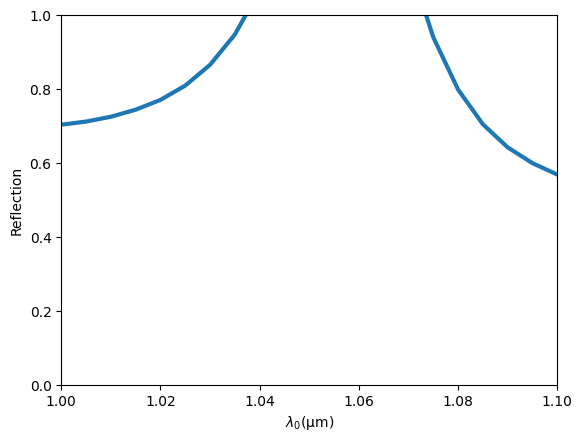

In [11]:
nval = len(ref_list)
#maybe we have aborted the execution
wl_plot = wl_list[:nval]
plot_data(wl_plot,ref_list,"Reflection")

## Computing PML parameter

In [ ]:
R=10**-7
n_mat = 1
alpha = -(2+1)*1.0*np.log(R)/(4*np.pi*n_mat*h_pml)
print(alpha)